In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set tensorflow log level, hide info, warning
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# force GPU device
os.environ["CUDA_VISIBLE_DEVICES"]='0'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import Sequential, Input

from sklearn.metrics import classification_report

2024-06-25 09:40:59.839969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


load data from csv

In [2]:
checkpoint_path = 'saves/ffnn'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [3]:
filter = True
filter_threshold = 5

data_directory = '/home/jrosendahl/datasets/cadets/sequences/'

data = []

labels = None
no_labels = None

no_features: int = None

count = 0
for file_name in os.listdir(data_directory):
    count += 1
    if count % 100000 == 0:
        print(f'Loaded {count} sequences')
    with open(data_directory + file_name, 'r') as f:
        label = file_name.split('_')[0]
        # build dictionary with counts of events
        datapoint = {}
        for line in f:
            line = line.strip()
            if line in datapoint:
                datapoint[line] += 1
            else:
                datapoint[line] = 1
        data.append((label, datapoint))

print(f'Loaded {len(data)} datapoints')


if filter:
    # filter out datapoints where label occurres less than 10 times
    label_occurrences = {}
    for label, _ in data:
        if label in label_occurrences:
            label_occurrences[label] += 1
        else:
            label_occurrences[label] = 1

    print(f'Filtered out datapoints with less than filter_threshold occurrences')
    data = [ x for x in data if label_occurrences[x[0]] >= filter_threshold ]
    print(f'Left with {len(data)} datapoints')

else:
    print(f'No filtering applied')

random.shuffle(data)
labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

# get distinct features
distinct_features = set()
for datapoint in data:
    distinct_features.update(datapoint.keys())
distinct_features = np.array(list(distinct_features))
no_features = len(distinct_features)
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
print(f'Encoded labels to one-hot')

# encode features from dictionary to numpy array
data_encoded = []
for datapoint in data:
    datapoint_encoded = np.zeros(no_features)
    for feature, count in datapoint.items():
        datapoint_encoded[distinct_features.tolist().index(feature)] = count
    data_encoded.append(datapoint_encoded)
print(f'Encoded features to numpy array')

Loaded 100000 sequences
Loaded 200000 sequences
Loaded 300000 sequences
Loaded 400000 sequences
Loaded 430863 datapoints
Filtered out datapoints with less than filter_threshold occurrences
Left with 430774 datapoints
Found 94 distinct labels
Found 29 distinct features
Encoded labels to one-hot
Encoded features to numpy array


build model

In [4]:
model = Sequential(layers=[
    Input(shape=(no_features,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(no_labels, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 94)             │         6,110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,350 (63.87 KB)

 Trainable params: 16,350 (63.87 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

model_checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-7
)

csv_logger = CSVLogger(
    filename=log_path,
    append=True
)


# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [6]:
# split data into training and validation
split = int(len(data_encoded) * 0.8)

X_train = np.array(data_encoded[:split])
y_train = np.array(labels[:split])

X_val = np.array(data_encoded[split:])
y_val = np.array(labels[split:])

print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')

Training on 344619 samples
Validating on 86155 samples


In [7]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger]
)

# save history to file
with open(f'{checkpoint_path}/ffn_history.npy', 'wb') as f:
    np.save(f, history.history)

Epoch 1/50


I0000 00:00:1719301290.215711  752658 service.cc:145] XLA service 0x7252c80045a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719301290.215770  752658 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


   58/10770 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.3178 - loss: 1.0083     

I0000 00:00:1719301291.003859  752658 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10770/10770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8783 - loss: 0.1717
Epoch 1: val_loss improved from inf to 0.03755, saving model to saves/ffnn/model.keras
10770/10770 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.8783 - loss: 0.1717 - val_accuracy: 0.9384 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 2/50
10755/10770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9352 - loss: 0.0455
Epoch 2: val_loss improved from 0.03755 to 0.03662, saving model to saves/ffnn/model.keras
10770/10770 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9352 - loss: 0.0455 - val_accuracy: 0.9389 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 3/50
10763/10770 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9379 - loss: 0.0373
Epoch 3: val_loss improved from 0.03662 to 0.03570, saving model to saves/ffnn/model.keras
10770/10770 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.9379 - loss: 0.0373 - val_accuracy: 0.9394 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 4/50
10762/10770 ━━━━━━━━━━━

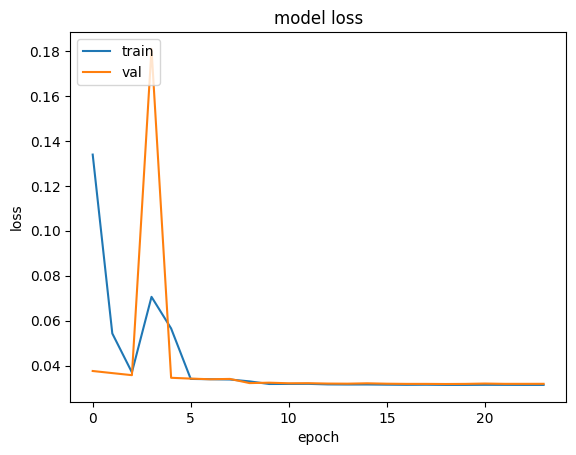

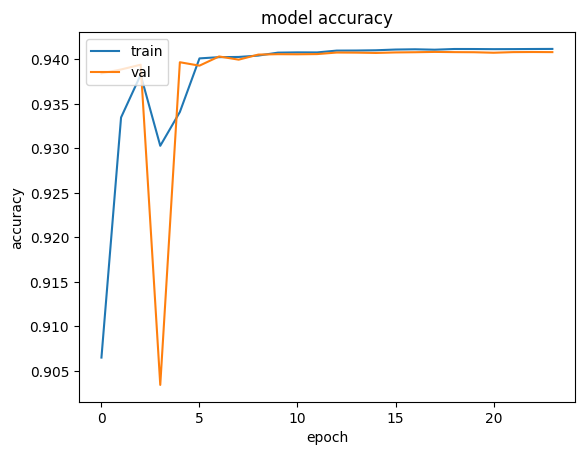

In [11]:
# plot history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# load model from file
model = tf.keras.models.load_model(model_path)

# evaluate model
score = model.evaluate(X_val, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

2693/2693 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9412 - loss: 0.0308
Test loss: 0.0317600853741169
Test accuracy: 0.9408159852027893


In [20]:
# print classification report
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred, target_names=distinct_labels, labels=np.arange(no_labels), zero_division=np.nan))

2693/2693 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
                 precision    recall  f1-score   support

      adjkerntz        nan      0.00      0.00        22
         alpine       1.00      0.46      0.63       211
          anvil       0.85      0.99      0.92       182
          atrun       1.00      1.00      1.00       636
            awk       0.94      1.00      0.97        15
       basename        nan      0.00      0.00         3
           bash       0.95      0.97      0.96     32068
          bzcat       0.22      1.00      0.36         2
          bzip2       1.00      0.50      0.67         2
            cat       0.97      0.98      0.98        65
         chkgrp        nan      0.00      0.00         1
        cleanup       1.00      1.00      1.00       244
            cmp       1.00      1.00      1.00         7
             cp       1.00      1.00      1.00         1
           cron       1.00      1.00      1.00      2022
            csh        nan      0.00      0.